In [1]:
cd ..

/gorani/gorani/backend/dataserver


In [9]:
# parameters
user_id = 1
dropout = 0.2
neuron = 64
outlie_time = 200

In [3]:
from gorani.tf import FEATURE_LEN, transform_paragraphs
from gorani.datadb import DataDB

data_db = DataDB()
ps = data_db.get_flipped_paragraphs(user_id)

x,y = transform_paragraphs(ps)
print(len(x), len(y))

4 4


In [10]:
import numpy as np
idx = np.where(y > outlie_time)
print(len(idx))
x = np.delete(x, idx, axis=0)
y= np.delete(y, idx, axis=0)
print(x.shape, y.shape)
print(x.dtype, y.dtype)

2
(2, 268, 44) (2, 1)
float32 float32


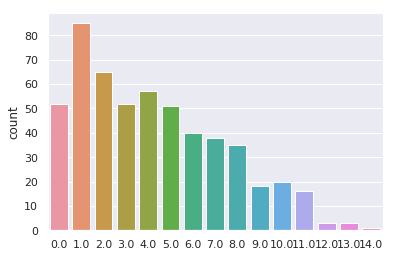

In [11]:
import seaborn as sns
sns.set(color_codes=True)
sns.countplot(x[:, :, FEATURE_LEN - 1].flatten())

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle= True)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
print(x_train.dtype, y_train.dtype)
print(FEATURE_LEN)

(1, 268, 44) (1, 1) (1, 268, 44) (1, 1)
float32 float32
44


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from typing import List
import time

with tf.Graph().as_default():
    with tf.Session() as sess:
        K.set_session(sess)
        model = Sequential()
        model.add(GRU(neuron, input_shape=(None, FEATURE_LEN), dropout=dropout, recurrent_dropout=dropout, kernel_initializer='he_uniform'))
        model.add(Dense(neuron, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adagrad')
        filepath = "out/{}-time-model-{}-{}-{}.hdf5".format(user_id, neuron, dropout, time.time())
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        tensorboard = TensorBoard(log_dir='out/logs/{}-{}-{}-time-model-{}'.format(user_id, neuron, dropout, time.time()), histogram_freq=1,
                                  write_graph=True, write_images=False)

        history = model.fit(x_train, y_train, epochs=50, batch_size=int(x_train.shape[0]/20+1), verbose=1, validation_data=(x_valid, y_valid), callbacks=[checkpoint, tensorboard])


Train on 1 samples, validate on 1 samples
Epoch 1/50

Epoch 00001: val_loss improved from inf to 83.64104, saving model to out/1-time-model-64-0.2-1558813727.3446398.hdf5
1/1 [==============================] - 1s 785ms/step - loss: 19.4907 - val_loss: 83.6410
Epoch 2/50

Epoch 00002: val_loss improved from 83.64104 to 83.02624, saving model to out/1-time-model-64-0.2-1558813727.3446398.hdf5
1/1 [==============================] - 0s 222ms/step - loss: 5.5135 - val_loss: 83.0262
Epoch 3/50

Epoch 00003: val_loss improved from 83.02624 to 82.24709, saving model to out/1-time-model-64-0.2-1558813727.3446398.hdf5
1/1 [==============================] - 0s 224ms/step - loss: 8.5403 - val_loss: 82.2471
Epoch 4/50

Epoch 00004: val_loss improved from 82.24709 to 81.89771, saving model to out/1-time-model-64-0.2-1558813727.3446398.hdf5
1/1 [==============================] - 0s 221ms/step - loss: 1.6020 - val_loss: 81.8977
Epoch 5/50

Epoch 00005: val_loss improved from 81.89771 to 81.62807, savi

Epoch 45/50

Epoch 00045: val_loss did not improve from 70.89989
1/1 [==============================] - 0s 209ms/step - loss: 0.0073 - val_loss: 71.3972
Epoch 46/50

Epoch 00046: val_loss did not improve from 70.89989
1/1 [==============================] - 0s 214ms/step - loss: 9.9087e-04 - val_loss: 71.3640
Epoch 47/50

Epoch 00047: val_loss did not improve from 70.89989
1/1 [==============================] - 0s 210ms/step - loss: 0.2146 - val_loss: 70.9604
Epoch 48/50

Epoch 00048: val_loss did not improve from 70.89989
1/1 [==============================] - 0s 213ms/step - loss: 0.2617 - val_loss: 71.5989
Epoch 49/50

Epoch 00049: val_loss did not improve from 70.89989
1/1 [==============================] - 0s 216ms/step - loss: 0.0012 - val_loss: 71.5697
Epoch 50/50

Epoch 00050: val_loss improved from 70.89989 to 70.70276, saving model to out/1-time-model-64-0.2-1558813727.3446398.hdf5
1/1 [==============================] - 0s 218ms/step - loss: 0.2236 - val_loss: 70.7028
